In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from lifelines import KaplanMeierFitter, CoxPHFitter
from sksurv.ensemble import RandomSurvivalForest
from sksurv.metrics import concordance_index_censored
# Load dataset
data_path = r"C:\Users\WA\New folder\BINF5507-Assignment1\assignment4\Data\RADCURE_Clinical_v04_20241219.xlsx"
df = pd.read_excel(data_path, engine = "openpyxl")

# Display dataset info
df.info()
df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3346 entries, 0 to 3345
Data columns (total 34 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   patient_id         3346 non-null   object        
 1   Age                3346 non-null   float64       
 2   Sex                3346 non-null   object        
 3   ECOG PS            3345 non-null   object        
 4   Smoking PY         3341 non-null   object        
 5   Smoking Status     3346 non-null   object        
 6   Ds Site            3346 non-null   object        
 7   Subsite            2972 non-null   object        
 8   T                  3334 non-null   object        
 9   N                  3333 non-null   object        
 10  M                  3332 non-null   object        
 11  Stage              3319 non-null   object        
 12  Path               3346 non-null   object        
 13  HPV                1717 non-null   object        
 14  Tx Modal

,patient_id,Age,Sex,ECOG PS,Smoking PY,Smoking Status,Ds Site,Subsite,T,N,...,Local,Date Local,Regional,Date Regional,Distant,Date Distant,2nd Ca,Date 2nd Ca,RADCURE-challenge,ContrastEnhanced
0,RADCURE-0005,62.6,Female,ECOG 0,50,Ex-smoker,Oropharynx,post wall,T4b,N2c,...,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,0,0
1,RADCURE-0006,87.3,Male,ECOG 2,25,Ex-smoker,Larynx,Glottis,T1b,N0,...,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,0,1
2,RADCURE-0007,49.9,Male,ECOG 1,15,Ex-smoker,Oropharynx,Tonsil,T3,N2b,...,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,0,1
3,RADCURE-0009,72.3,Male,ECOG 1,30,Ex-smoker,Unknown,NaN,T0,N2c,...,NaN,NaT,NaN,NaT,NaN,NaT,S (suspicious),2008-05-27,0,0
4,RADCURE-0010,59.7,Female,ECOG 0,0,Non-smoker,Oropharynx,Tonsillar Fossa,T4b,N0,...,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,0,0


# Preprocess Data for Survival Analysis



In [53]:
# Convert event indicator to binary: 1 = Death, 0 = Alive
df["event"] = np.where(df["Status"] == "Dead", 1, 0)

# Define survival time
df["survival_time"] = df["Length FU"]

# Define groups (Tumor Stage)
df["Stage Group"] = df["Stage"].replace({"I": "Early", "II": "Early", "III": "Advanced", "IV": "Advanced"})
df = df.dropna(subset=["Stage Group", "survival_time", "event"])


# Kaplan-Meier Survival Analysis

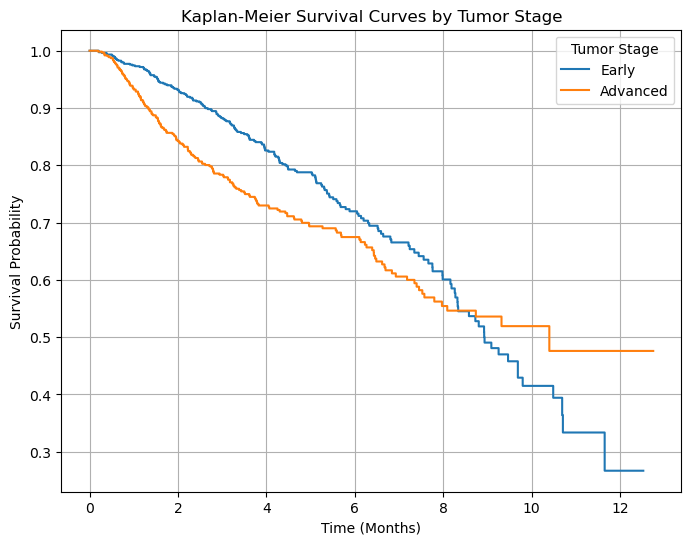

,test_statistic,p,-log2(p)
0,5.519566,0.018805,5.732746


In [27]:
# Initialize Kaplan-Meier estimator
kmf = KaplanMeierFitter()

# Plot survival curves for different tumor stages
plt.figure(figsize=(8, 6))
for stage in ["Early", "Advanced"]:
    mask = df["Stage Group"] == stage
    kmf.fit(df.loc[mask, "survival_time"], df.loc[mask, "event"], label=stage)
    kmf.plot_survival_function(ci_show=False)

plt.title("Kaplan-Meier Survival Curves by Tumor Stage")
plt.xlabel("Time (Months)")
plt.ylabel("Survival Probability")
plt.legend(title="Tumor Stage")
plt.grid(True)
plt.show()

# Log-rank test
early_group = df[df["Stage Group"] == "Early"]
advanced_group = df[df["Stage Group"] == "Advanced"]
logrank_results = logrank_test(early_group["survival_time"], advanced_group["survival_time"], 
                               event_observed_A=early_group["event"], event_observed_B=advanced_group["event"])
logrank_results.summary


# Cox Proportional Hazards Regression


<lifelines.CoxPHFitter: fitted with 1713 total observations, 1250 right-censored observations>
             duration col = 'survival_time'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 1713
number of events observed = 463
   partial log-likelihood = -3070.06
         time fit was run = 2025-03-13 02:52:30 UTC

---
                              coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                     
Stage Group_Advanced         14.25  1.54e+06   1021.40        -1987.66         2016.16                0.00                 inf
Stage Group_Early            13.43  6.78e+05   1021.40        -1988.48         2015.34                0.00                 inf
Stage Group_IVA              14.60  2.19e+06   1021.40        -1987.31         2016.51                0.00                 inf
Stage Group_IVB              15.12  3.67e+06   1021.40        -1986.79         2017.03                0.00                 inf
Stage Group_IVC               0.44      1.55   3303.66        -6474.62         6475.50                0.00                 inf
Tx Modality_ChemoRT         -13.27      0.00   2261.80        -4446.31         4419.77                0.00                 inf
Tx Modality_Postop RT alone -14.48      0.00   3149.83        -6188.04         6159.07                0.00                 inf
Tx Modality_RT + EGFRI        0.82      2.28      0.22            0.38            1.27                1.47                3.55
Tx Modality_RT alone          0.93      2.54      0.10            0.73            1.13                2.07                3.11
HPV_Yes, positive            -1.26      0.28      0.10           -1.45           -1.06                0.23                0.35

                             cmp to      z      p  -log2(p)
covariate                                                  
Stage Group_Advanced           0.00   0.01   0.99      0.02
Stage Group_Early              0.00   0.01   0.99      0.02
Stage Group_IVA                0.00   0.01   0.99      0.02
Stage Group_IVB                0.00   0.01   0.99      0.02
Stage Group_IVC                0.00   0.00   1.00      0.00
Tx Modality_ChemoRT            0.00  -0.01   1.00      0.01
Tx Modality_Postop RT alone    0.00  -0.00   1.00      0.01
Tx Modality_RT + EGFRI         0.00   3.67 <0.005     12.00
Tx Modality_RT alone           0.00   9.01 <0.005     62.04
HPV_Yes, positive              0.00 -12.66 <0.005    119.61
---
Concordance = 0.74
Partial AIC = 6160.12
log-likelihood ratio test = 297.14 on 10 df
-log2(p) of ll-ratio test = 190.02

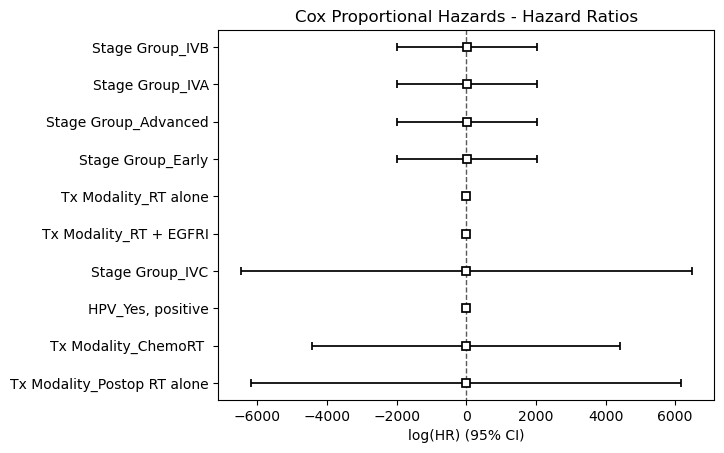

In [41]:
from lifelines import CoxPHFitter

# Select relevant columns
cox_data = df[["survival_time", "event", "Stage Group", "Tx Modality", "HPV"]].dropna()

# Encode categorical variables
cox_data = pd.get_dummies(cox_data, drop_first=True)

# Fit Cox model
cph = CoxPHFitter()


cph.fit(cox_data, duration_col="survival_time", event_col="event")

# Display summary of the model
cph.print_summary()

# Plot hazard ratios
cph.plot()
plt.title("Cox Proportional Hazards - Hazard Ratios")
plt.show()




# Random Survival Forests (RSF)

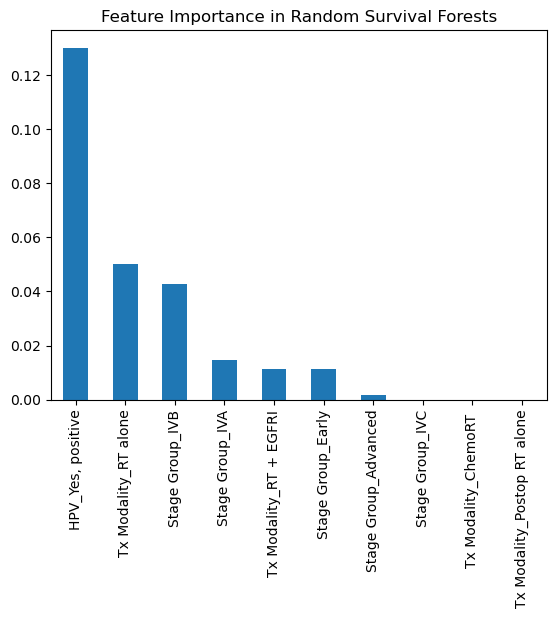

RSF C-Index: 0.746
Cox C-Index: 0.739


In [54]:
from sksurv.ensemble import RandomSurvivalForest
from sksurv.util import Surv
from sksurv.metrics import concordance_index_censored

# Prepare survival data
rsf_data = df[["survival_time", "event", "Stage Group", "Tx Modality", "HPV"]].dropna()
rsf_data = pd.get_dummies(rsf_data, drop_first=True)

# Convert data to structured array
y_rsf = Surv.from_dataframe("event", "survival_time", rsf_data)
X_rsf = rsf_data.drop(columns=["survival_time", "event"])

# Train RSF model
rsf = RandomSurvivalForest(n_estimators=100, min_samples_split=10, random_state=42)
rsf.fit(X_rsf, y_rsf)


def compute_feature_importance(rsf, X, y):
    """Compute feature importance based on decrease in C-index."""
    baseline_cindex = rsf.score(X, y)  # C-index with all features
    importances = {}

    for feature in X.columns:
        X_permuted = X.copy()
        X_permuted[feature] = np.random.permutation(X_permuted[feature])  # Shuffle feature
        permuted_cindex = rsf.score(X_permuted, y)  # C-index after shuffling
        importances[feature] = baseline_cindex - permuted_cindex  # Importance = C-index drop
    
    return importances

# Compute feature importance
feature_importance = compute_feature_importance(rsf, X_rsf, y_rsf)

# Convert to Pandas Series and plot
importances_series = pd.Series(feature_importance).sort_values(ascending=False)
importances_series.plot(kind="bar", title="Feature Importance in Random Survival Forests")
plt.show()

# Compute feature importance
feature_importance = compute_feature_importance(rsf, X_rsf, y_rsf)

# Convert to Pandas Series and plot
importances_series = pd.Series(feature_importance).sort_values(ascending=False)

# Compare C-index
c_index_rsf = rsf.score(X_rsf, y_rsf)
cph.fit(rsf_data, duration_col="survival_time", event_col="event")
c_index_cox = cph.concordance_index_

print(f"RSF C-Index: {c_index_rsf:.3f}")
print(f"Cox C-Index: {c_index_cox:.3f}")
